### Importando os Dados

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Importando e entendendo os dados

In [2]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


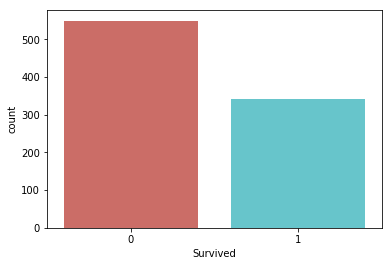

In [3]:
# Target é binário?
sb.countplot(x='Survived',data=titanic, palette='hls')

Dados da variável target são binários e pouco desbalanceados

In [4]:
# forma dos dados
titanic.shape

(891, 12)

In [5]:
# verificando por NAs
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Temos os dados de Idade e Cabine com informações faltantes

In [6]:
# Temos que os dados de identificação do passageiro, seu nome, o número
# do ticket e a identificação da cabine são features não generalizáveis.
# Portanto, vamos retirá-las do treinamento
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Tratando os dados faltantes

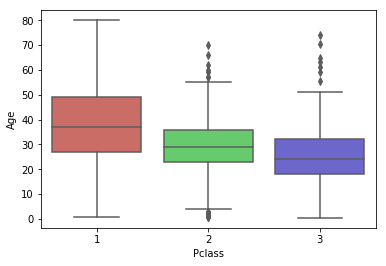

In [7]:
# Avaliando se a variável idade é influenciada pela classe do passageiro
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [8]:
# Vemos que passageiros da primeira classe têm mediana por volta dos 37 anos,
# da segunda classe têm mediana em cerca de 29 anos e terceira classe em cerca
# de 24 anos.

# Desta forma, vamos definir uma função para imputar dados faltantes de idade
# de acordo com a classe:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age


# Após definir a função, aplica-se a imputação nos dados
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

# verificando o resultado final
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [9]:
# Vemos que a variáveis 'Embarked' tem 2 valores nulos. Vamos eliminá-los, uma
# vez que 2 registros são dispensáveis dentro do total
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Entendendo variáveis categóricas

In [10]:
# analisando a quantidade de valores únicos por coluna:
titanic_data.nunique()

Survived      2
Pclass        3
Sex           2
Age          88
SibSp         7
Parch         7
Fare        247
Embarked      3
dtype: int64

Temos as *Features* categóricas: **Sex e Embarked**.

In [11]:
titanic_data = pd.get_dummies(titanic_data, columns=['Sex', 'Embarked'], 
                              prefix=['Sex', 'Embarked'], drop_first=True)

In [12]:
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### Segregando os dados em Treino e Teste

In [13]:
titanic_data = titanic_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 
                             'Embarked_Q', 'Embarked_S', 'Survived']]

In [14]:
# Features
X = titanic_data.iloc[:,:-1].values

# Target
y = titanic_data.iloc[:,-1].values

# Dados com StandardScaler
X_std = StandardScaler().fit_transform(X)

# Dados com MinMaxScaler
X_minmax = MinMaxScaler().fit_transform(X)

############# Dividindo em Treino e Teste (80~20%)
# StandardScaler
X_train_s, X_test_s, y_train, y_test = train_test_split(X_std, y,
                                                        test_size = .2,
                                                        random_state=42)

# MinMaxScaler
X_train_m, X_test_m, _, _ = train_test_split(X_minmax, y, 
                                             test_size = .2,
                                             random_state=42)

In [15]:
# definindo grade de parâmetros a testar
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}

##### Testando com dados Padronizados

In [16]:
############
## Obs: Nesta etapa, não conseguimos testar o kernel 'poly', pois travava o treinamento todas as
## vezes que testamos

In [17]:
# buscando a melhor busca de parâmetros para dados PADRONIZADOS
grid_search = GridSearchCV(SVC(), param_grid, verbose = 8, 
                           cv=5, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train_s, y_train) 

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 423 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    7.7s finished


In [18]:
# imprimindo o resultado
grid_search.best_score_

0.8298138481237073

In [19]:
bestSVM = grid_search.best_estimator_
y_pred = bestSVM.predict(X_test_s)

In [20]:
# imprimindo o relatório de resultados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       109
           1       0.79      0.72      0.76        69

    accuracy                           0.82       178
   macro avg       0.81      0.80      0.81       178
weighted avg       0.82      0.82      0.82       178



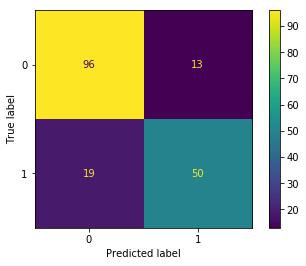

In [21]:
# imprimindo a matriz de confusão
plot_confusion_matrix(bestSVM, X_test_s, y_test)

#### Testando com dados Normalizados

In [22]:
# definindo grade de parâmetros a testar
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid', 'linear']}

In [23]:
# buscando a melhor busca de parâmetros para dados PADRONIZADOS
grid_search = GridSearchCV(SVC(), param_grid, verbose = 8, 
                           cv=5, n_jobs=-1, scoring='accuracy')
grid_result = grid_search.fit(X_train_m, y_train) 

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   21.4s finished


In [24]:
# imprimindo o resultado
grid_search.best_score_

0.8270067960208806

In [25]:
# imprimindo o relatório de resultados
bestSVM = grid_search.best_estimator_
y_pred = bestSVM.predict(X_test_m)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       109
           1       0.84      0.70      0.76        69

    accuracy                           0.83       178
   macro avg       0.83      0.81      0.82       178
weighted avg       0.83      0.83      0.83       178



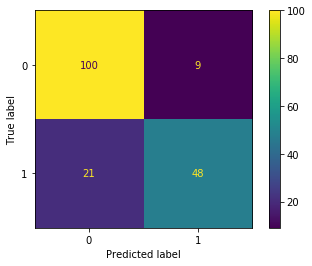

In [26]:
# imprimindo a matriz de confusão
plot_confusion_matrix(bestSVM, X_test_m, y_test)

Observa-se, comparando os resultados com os os dados normalizados vs. padronizados, uma leve vantagem nos **dados normalizados**.

Os parâmetros do modelo que levam à melhor acurácia são:

In [28]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}